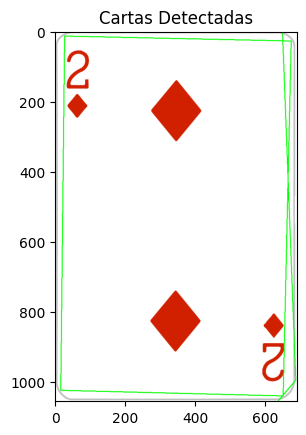

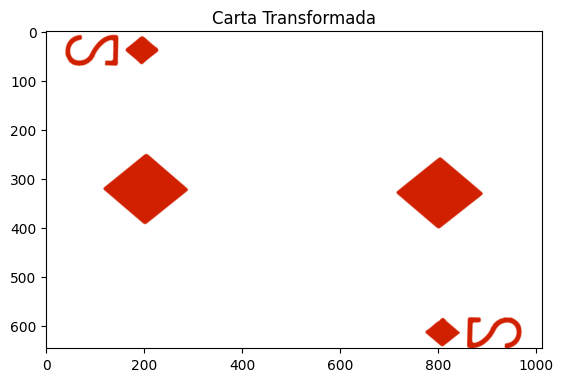

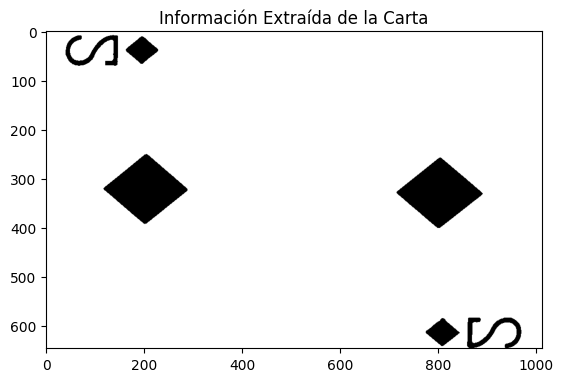

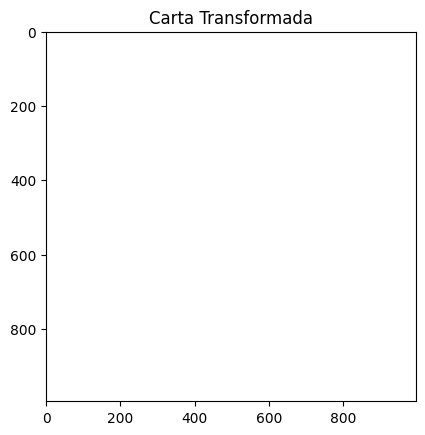

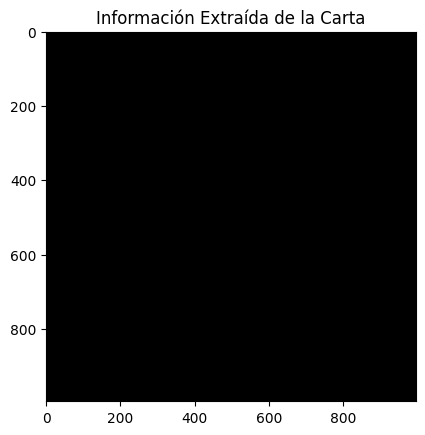

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para preprocesar la imagen: convertir a escala de grises, aplicar filtro gaussiano y mejorar el contraste.
def preprocess_image(image):
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Aplicar filtro gaussiano para reducir ruido
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Mejorar el contraste con una ecualización de histograma
    enhanced = cv2.equalizeHist(blurred)
    return enhanced

# Función para detectar los bordes utilizando el algoritmo de Canny
def detect_edges(image):
    # Detectar bordes con Canny
    edges = cv2.Canny(image, 100, 200)
    return edges

# Función para encontrar los contornos de las cartas en la imagen
def find_cards_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Función para filtrar contornos de la carta
def filter_card_contours(contours):
    card_contours = []
    for contour in contours:
        # Aproximación de los contornos
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Filtramos solo los contornos con 4 vértices
        if len(approx) == 4:
            card_contours.append(approx)
    return card_contours

# Función para transformar la perspectiva de la carta a una vista frontal
def transform_perspective(image, contour):
    # Definir puntos de la perspectiva inicial y final (debe ser ajustado según el contorno)
    pts1 = np.float32([contour[0][0], contour[1][0], contour[2][0], contour[3][0]])
    width = max(np.linalg.norm(pts1[0] - pts1[1]), np.linalg.norm(pts1[2] - pts1[3]))
    height = max(np.linalg.norm(pts1[0] - pts1[3]), np.linalg.norm(pts1[1] - pts1[2]))
    pts2 = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
    
    # Matriz de transformación de perspectiva
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    
    # Realizar la transformación de perspectiva
    warped = cv2.warpPerspective(image, matrix, (int(width), int(height)))
    
    return warped

# Función para extraer información de la carta (valor y palo)
def extract_card_info(card_image):
    # Convertir a escala de grises y binarizar
    gray = cv2.cvtColor(card_image, cv2.COLOR_BGR2GRAY)
    _, binarized = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Aquí se puede realizar un análisis de plantillas, por ejemplo, comparar con plantillas de los números y palos.
    # Se puede usar una red neuronal para reconocimiento de caracteres o buscar plantillas para cada número y palo.
    # Este paso debe ser personalizado con tus propias plantillas o red de reconocimiento.
    
    return binarized

# Cargar la imagen
image = cv2.imread('Fotos/fotos_sencillas/2D.png')

# Preprocesar la imagen
preprocessed_image = preprocess_image(image)

# Detectar bordes
edges = detect_edges(preprocessed_image)

# Encontrar los contornos en la imagen
contours = find_cards_contours(edges)

# Filtrar los contornos que corresponden a cartas
card_contours = filter_card_contours(contours)

# Dibujar los contornos de las cartas en la imagen original
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, card_contours, -1, (0, 255, 0), 2)

# Mostrar la imagen con los contornos detectados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Cartas Detectadas")
plt.show()

# Para cada carta detectada, obtener la subimagen transformada
for contour in card_contours:
    card_image = transform_perspective(image, contour)
    
    # Mostrar la carta transformada
    plt.imshow(cv2.cvtColor(card_image, cv2.COLOR_BGR2RGB))
    plt.title("Carta Transformada")
    plt.show()
    
    # Extraer la información de la carta
    card_info = extract_card_info(card_image)
    
    # Mostrar la información extraída
    plt.imshow(card_info, cmap='gray')
    plt.title("Información Extraída de la Carta")
    plt.show()


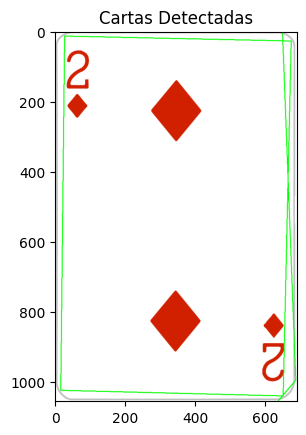

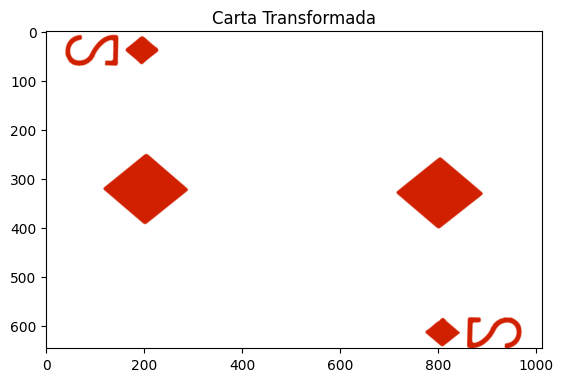

La carta detectada es: 7 de Hearts


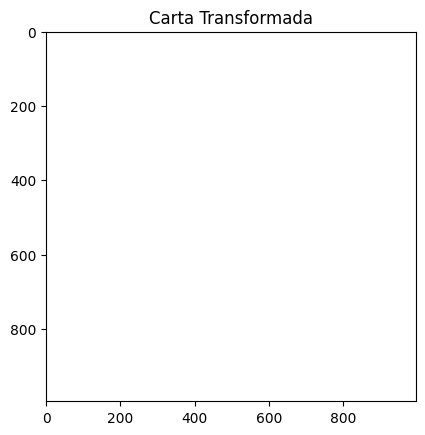

La carta detectada es: Ace de Clubs


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para preprocesar la imagen: convertir a escala de grises, aplicar filtro gaussiano y mejorar el contraste.
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    enhanced = cv2.equalizeHist(blurred)
    return enhanced

# Función para detectar los bordes utilizando el algoritmo de Canny
def detect_edges(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

# Función para encontrar los contornos de las cartas en la imagen
def find_cards_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Función para filtrar contornos de la carta
def filter_card_contours(contours):
    card_contours = []
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if len(approx) == 4:
            card_contours.append(approx)
    return card_contours

# Función para transformar la perspectiva de la carta a una vista frontal
def transform_perspective(image, contour):
    pts1 = np.float32([contour[0][0], contour[1][0], contour[2][0], contour[3][0]])
    width = max(np.linalg.norm(pts1[0] - pts1[1]), np.linalg.norm(pts1[2] - pts1[3]))
    height = max(np.linalg.norm(pts1[0] - pts1[3]), np.linalg.norm(pts1[1] - pts1[2]))
    pts2 = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
    
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    warped = cv2.warpPerspective(image, matrix, (int(width), int(height)))
    return warped

# Función para extraer información de la carta (valor y palo)
def extract_card_info(card_image, number_templates, suit_templates):
    gray_card = cv2.cvtColor(card_image, cv2.COLOR_BGR2GRAY)
    
    # Comparar con plantillas de números
    number_res = []
    for name, template in number_templates.items():
        result = cv2.matchTemplate(gray_card, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        number_res.append((name, max_val, max_loc))
    
    number_res.sort(key=lambda x: x[1], reverse=True)
    number = number_res[0][0]
    
    # Comparar con plantillas de palos
    suit_res = []
    for name, template in suit_templates.items():
        result = cv2.matchTemplate(gray_card, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        suit_res.append((name, max_val, max_loc))
    
    suit_res.sort(key=lambda x: x[1], reverse=True)
    suit = suit_res[0][0]
    
    return number, suit

# Cargar las plantillas de los números y los palos
def load_templates():
    number_templates = {}
    suit_templates = {}
    
    # Plantillas de números
    number_templates['Ace'] = cv2.imread('Fotos/Plantillas/Ace.jpg', 0)  # Ejemplo
    number_templates['2'] = cv2.imread('Fotos/Plantillas/Two.jpg', 0)
    number_templates['3'] = cv2.imread('Fotos/Plantillas/Three.jpg', 0)
    number_templates['4'] = cv2.imread('Fotos/Plantillas/Four.jpg', 0)
    number_templates['5'] = cv2.imread('Fotos/Plantillas/Five.jpg', 0)
    number_templates['6'] = cv2.imread('Fotos/Plantillas/Six.jpg', 0)
    number_templates['7'] = cv2.imread('Fotos/Plantillas/Seven.jpg', 0)
    number_templates['8'] = cv2.imread('Fotos/Plantillas/Eight.jpg', 0)
    number_templates['9'] = cv2.imread('Fotos/Plantillas/Nine.jpg', 0)
    number_templates['10'] = cv2.imread('Fotos/Plantillas/Ten.jpg', 0)
    number_templates['Jack'] = cv2.imread('Fotos/Plantillas/Jack.jpg', 0)
    number_templates['Queen'] = cv2.imread('Fotos/Plantillas/Queen.jpg', 0)
    number_templates['King'] = cv2.imread('Fotos/Plantillas/King.jpg', 0)
    
    # Plantillas de palos
    suit_templates['Clubs'] = cv2.imread('Fotos/Plantillas//Clubs.jpg', 0)
    suit_templates['Diamonds'] = cv2.imread('Fotos/Plantillas//Diamonds.jpg', 0)
    suit_templates['Hearts'] = cv2.imread('Fotos/Plantillas//Hearts.jpg', 0)
    suit_templates['Spades'] = cv2.imread('Fotos/Plantillas//Spades.jpg', 0)
    
    return number_templates, suit_templates

# Cargar la imagen
image = cv2.imread('Fotos/fotos_sencillas/2D.png')

# Preprocesar la imagen
preprocessed_image = preprocess_image(image)

# Detectar bordes
edges = detect_edges(preprocessed_image)

# Encontrar los contornos en la imagen
contours = find_cards_contours(edges)

# Filtrar los contornos que corresponden a cartas
card_contours = filter_card_contours(contours)

# Dibujar los contornos de las cartas en la imagen original
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, card_contours, -1, (0, 255, 0), 2)

# Mostrar la imagen con los contornos detectados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Cartas Detectadas")
plt.show()

# Cargar las plantillas
number_templates, suit_templates = load_templates()

# Para cada carta detectada, obtener la subimagen transformada
for contour in card_contours:
    card_image = transform_perspective(image, contour)
    
    # Mostrar la carta transformada
    plt.imshow(cv2.cvtColor(card_image, cv2.COLOR_BGR2RGB))
    plt.title("Carta Transformada")
    plt.show()
    
    # Extraer la información de la carta usando plantillas de números y palos
    number, suit = extract_card_info(card_image, number_templates, suit_templates)
    
    # Mostrar la información extraída
    print(f'La carta detectada es: {number} de {suit}')


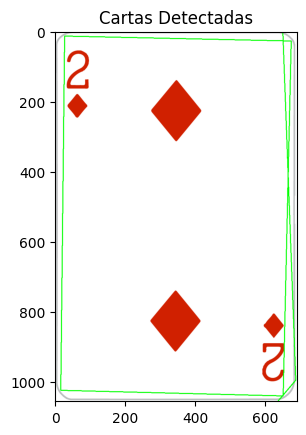

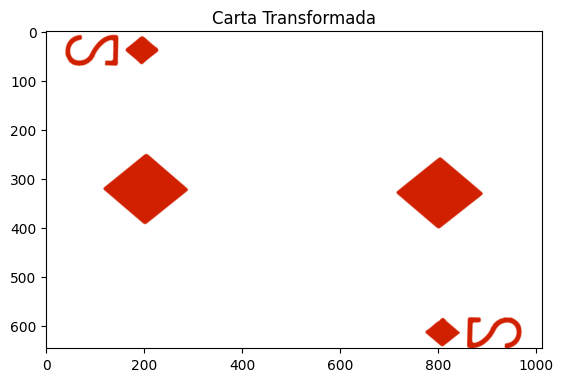

La carta detectada es: 7 de Hearts


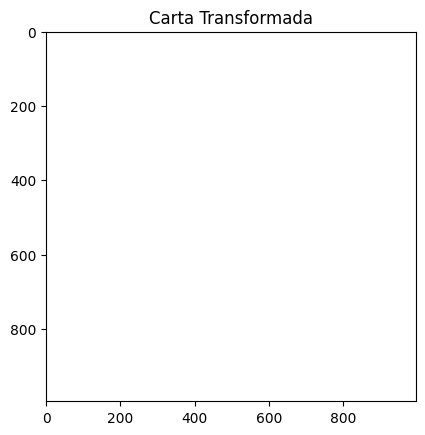

La carta detectada es: Ace de Clubs


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para preprocesar la imagen: convertir a escala de grises, aplicar filtro gaussiano y mejorar el contraste.
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    enhanced = cv2.equalizeHist(blurred)  # Mejorar el contraste
    _, thresholded = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Binarizar
    return thresholded

# Función para detectar los bordes utilizando el algoritmo de Canny
def detect_edges(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

# Función para encontrar los contornos de las cartas en la imagen
def find_cards_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Función para filtrar contornos de la carta
def filter_card_contours(contours):
    card_contours = []
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            card_contours.append(approx)
    return card_contours

# Función para transformar la perspectiva de la carta a una vista frontal
def transform_perspective(image, contour):
    pts1 = np.float32([contour[0][0], contour[1][0], contour[2][0], contour[3][0]])
    width = max(np.linalg.norm(pts1[0] - pts1[1]), np.linalg.norm(pts1[2] - pts1[3]))
    height = max(np.linalg.norm(pts1[0] - pts1[3]), np.linalg.norm(pts1[1] - pts1[2]))
    pts2 = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    warped = cv2.warpPerspective(image, matrix, (int(width), int(height)))
    return warped

# Función para extraer información de la carta (valor y palo)
def extract_card_info(card_image, number_templates, suit_templates):
    gray_card = cv2.cvtColor(card_image, cv2.COLOR_BGR2GRAY)
    _, thresholded_card = cv2.threshold(gray_card, 127, 255, cv2.THRESH_BINARY)
    
    # Comparar con plantillas de números
    number_res = []
    for name, template in number_templates.items():
        result = cv2.matchTemplate(thresholded_card, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        number_res.append((name, max_val))
    
    number_res.sort(key=lambda x: x[1], reverse=True)
    number = number_res[0][0]
    
    # Comparar con plantillas de palos
    suit_res = []
    for name, template in suit_templates.items():
        result = cv2.matchTemplate(thresholded_card, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        suit_res.append((name, max_val))
    
    suit_res.sort(key=lambda x: x[1], reverse=True)
    suit = suit_res[0][0]
    
    return number, suit

# Cargar las plantillas de los números y los palos
def load_templates():
    number_templates = {}
    suit_templates = {}
    
    # Plantillas de números
    number_templates['Ace'] = cv2.imread('Fotos/Plantillas/Ace.jpg', 0)
    number_templates['2'] = cv2.imread('Fotos/Plantillas/Two.jpg', 0)
    number_templates['3'] = cv2.imread('Fotos/Plantillas/Three.jpg', 0)
    number_templates['4'] = cv2.imread('Fotos/Plantillas/Four.jpg', 0)
    number_templates['5'] = cv2.imread('Fotos/Plantillas/Five.jpg', 0)
    number_templates['6'] = cv2.imread('Fotos/Plantillas/Six.jpg', 0)
    number_templates['7'] = cv2.imread('Fotos/Plantillas/Seven.jpg', 0)
    number_templates['8'] = cv2.imread('Fotos/Plantillas/Eight.jpg', 0)
    number_templates['9'] = cv2.imread('Fotos/Plantillas/Nine.jpg', 0)
    number_templates['10'] = cv2.imread('Fotos/Plantillas/Ten.jpg', 0)
    number_templates['Jack'] = cv2.imread('Fotos/Plantillas/Jack.jpg', 0)
    number_templates['Queen'] = cv2.imread('Fotos/Plantillas/Queen.jpg', 0)
    number_templates['King'] = cv2.imread('Fotos/Plantillas/King.jpg', 0)
    
    # Plantillas de palos
    suit_templates['Clubs'] = cv2.imread('Fotos/Plantillas/Clubs.jpg', 0)
    suit_templates['Diamonds'] = cv2.imread('Fotos/Plantillas/Diamonds.jpg', 0)
    suit_templates['Hearts'] = cv2.imread('Fotos/Plantillas/Hearts.jpg', 0)
    suit_templates['Spades'] = cv2.imread('Fotos/Plantillas/Spades.jpg', 0)
    
    return number_templates, suit_templates

# Cargar la imagen
image = cv2.imread('Fotos/fotos_sencillas/2D.png')

# Preprocesar la imagen
preprocessed_image = preprocess_image(image)

# Detectar bordes
edges = detect_edges(preprocessed_image)

# Encontrar los contornos en la imagen
contours = find_cards_contours(edges)

# Filtrar los contornos que corresponden a cartas
card_contours = filter_card_contours(contours)

# Dibujar los contornos de las cartas en la imagen original
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, card_contours, -1, (0, 255, 0), 2)

# Mostrar la imagen con los contornos detectados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Cartas Detectadas")
plt.show()

# Cargar las plantillas
number_templates, suit_templates = load_templates()

# Para cada carta detectada, obtener la subimagen transformada
for contour in card_contours:
    card_image = transform_perspective(image, contour)
    
    # Mostrar la carta transformada
    plt.imshow(cv2.cvtColor(card_image, cv2.COLOR_BGR2RGB))
    plt.title("Carta Transformada")
    plt.show()
    
    # Extraer la información de la carta usando plantillas de números y palos
    number, suit = extract_card_info(card_image, number_templates, suit_templates)
    
    # Mostrar la información extraída
    print(f'La carta detectada es: {number} de {suit}')


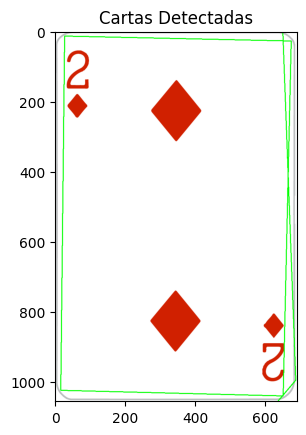

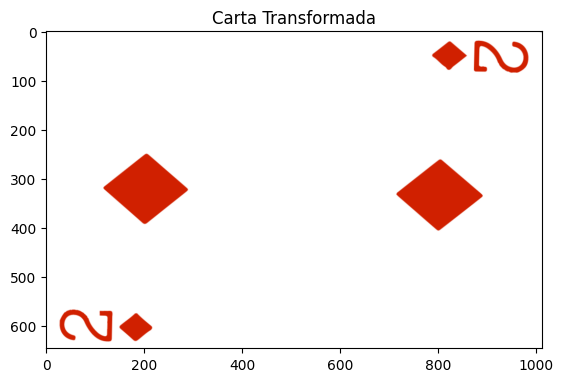

La carta detectada es: 7 de Hearts


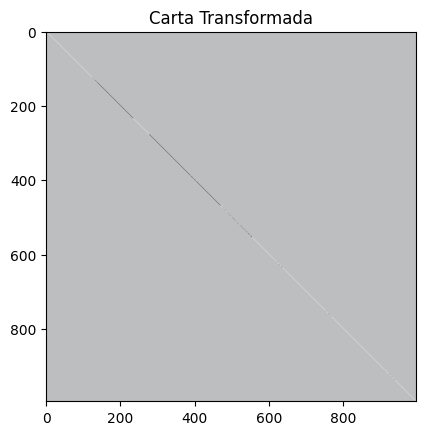

La carta detectada es: 3 de Hearts


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para preprocesar la imagen: convertir a escala de grises, aplicar filtro gaussiano y mejorar el contraste.
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    enhanced = cv2.equalizeHist(blurred)  # Mejorar el contraste
    _, thresholded = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Binarizar
    return thresholded

# Función para detectar los bordes utilizando el algoritmo de Canny
def detect_edges(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

# Función para encontrar los contornos de las cartas en la imagen
def find_cards_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Función para filtrar contornos de la carta
def filter_card_contours(contours):
    card_contours = []
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            card_contours.append(approx)
    return card_contours

# Función para transformar la perspectiva de la carta a una vista frontal en espejo
def transform_perspective(image, contour):
    # Obtener el tamaño de la imagen
    image_width = image.shape[1]
    
    # Ajustar el orden de los puntos de contorno (para reflejar la imagen en espejo)
    pts1 = np.float32([contour[0][0], contour[1][0], contour[2][0], contour[3][0]])

    # Reflejar las coordenadas horizontales (invirtiendo el eje X)
    pts1_mirror = np.float32([[image_width - pt[0], pt[1]] for pt in pts1])
    
    # Calcular la anchura y la altura de la carta transformada
    width = max(np.linalg.norm(pts1_mirror[0] - pts1_mirror[1]), np.linalg.norm(pts1_mirror[2] - pts1_mirror[3]))
    height = max(np.linalg.norm(pts1_mirror[0] - pts1_mirror[3]), np.linalg.norm(pts1_mirror[1] - pts1_mirror[2]))
    
    # Definir los puntos de salida de la transformación de perspectiva
    pts2 = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
    
    # Definir la matriz de transformación
    matrix = cv2.getPerspectiveTransform(pts1_mirror, pts2)
    
    # Realizar la transformación de perspectiva
    warped = cv2.warpPerspective(image, matrix, (int(width), int(height)))
    return warped


# Función para extraer información de la carta (valor y palo)
def extract_card_info(card_image, number_templates, suit_templates):
    gray_card = cv2.cvtColor(card_image, cv2.COLOR_BGR2GRAY)
    _, thresholded_card = cv2.threshold(gray_card, 127, 255, cv2.THRESH_BINARY)
    
    # Comparar con plantillas de números
    number_res = []
    for name, template in number_templates.items():
        result = cv2.matchTemplate(thresholded_card, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        number_res.append((name, max_val))
    
    number_res.sort(key=lambda x: x[1], reverse=True)
    number = number_res[0][0]
    
    # Comparar con plantillas de palos
    suit_res = []
    for name, template in suit_templates.items():
        result = cv2.matchTemplate(thresholded_card, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        suit_res.append((name, max_val))
    
    suit_res.sort(key=lambda x: x[1], reverse=True)
    suit = suit_res[0][0]
    
    return number, suit

# Cargar las plantillas de los números y los palos
def load_templates():
    number_templates = {}
    suit_templates = {}
    
    # Plantillas de números
    number_templates['Ace'] = cv2.imread('Fotos/Plantillas/Ace.jpg', 0)
    number_templates['2'] = cv2.imread('Fotos/Plantillas/Two.jpg', 0)
    number_templates['3'] = cv2.imread('Fotos/Plantillas/Three.jpg', 0)
    number_templates['4'] = cv2.imread('Fotos/Plantillas/Four.jpg', 0)
    number_templates['5'] = cv2.imread('Fotos/Plantillas/Five.jpg', 0)
    number_templates['6'] = cv2.imread('Fotos/Plantillas/Six.jpg', 0)
    number_templates['7'] = cv2.imread('Fotos/Plantillas/Seven.jpg', 0)
    number_templates['8'] = cv2.imread('Fotos/Plantillas/Eight.jpg', 0)
    number_templates['9'] = cv2.imread('Fotos/Plantillas/Nine.jpg', 0)
    number_templates['10'] = cv2.imread('Fotos/Plantillas/Ten.jpg', 0)
    number_templates['Jack'] = cv2.imread('Fotos/Plantillas/Jack.jpg', 0)
    number_templates['Queen'] = cv2.imread('Fotos/Plantillas/Queen.jpg', 0)
    number_templates['King'] = cv2.imread('Fotos/Plantillas/King.jpg', 0)
    
    # Plantillas de palos
    suit_templates['Clubs'] = cv2.imread('Fotos/Plantillas/Clubs.jpg', 0)
    suit_templates['Diamonds'] = cv2.imread('Fotos/Plantillas/Diamonds.jpg', 0)
    suit_templates['Hearts'] = cv2.imread('Fotos/Plantillas/Hearts.jpg', 0)
    suit_templates['Spades'] = cv2.imread('Fotos/Plantillas/Spades.jpg', 0)
    
    return number_templates, suit_templates

# Cargar la imagen
image = cv2.imread('Fotos/fotos_sencillas/2D.png')

# Preprocesar la imagen
preprocessed_image = preprocess_image(image)

# Detectar bordes
edges = detect_edges(preprocessed_image)

# Encontrar los contornos en la imagen
contours = find_cards_contours(edges)

# Filtrar los contornos que corresponden a cartas
card_contours = filter_card_contours(contours)

# Dibujar los contornos de las cartas en la imagen original
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, card_contours, -1, (0, 255, 0), 2)

# Mostrar la imagen con los contornos detectados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Cartas Detectadas")
plt.show()

# Cargar las plantillas
number_templates, suit_templates = load_templates()

# Para cada carta detectada, obtener la subimagen transformada
for contour in card_contours:
    card_image = transform_perspective(image, contour)
    
    # Mostrar la carta transformada
    plt.imshow(cv2.cvtColor(card_image, cv2.COLOR_BGR2RGB))
    plt.title("Carta Transformada")
    plt.show()
    
    # Extraer la información de la carta usando plantillas de números y palos
    number, suit = extract_card_info(card_image, number_templates, suit_templates)
    
    # Mostrar la información extraída
    print(f'La carta detectada es: {number} de {suit}')


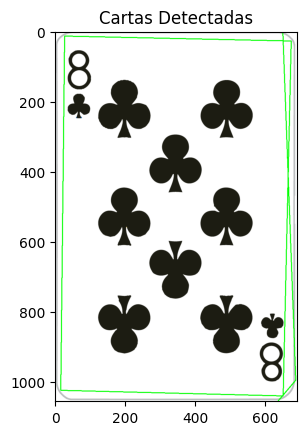

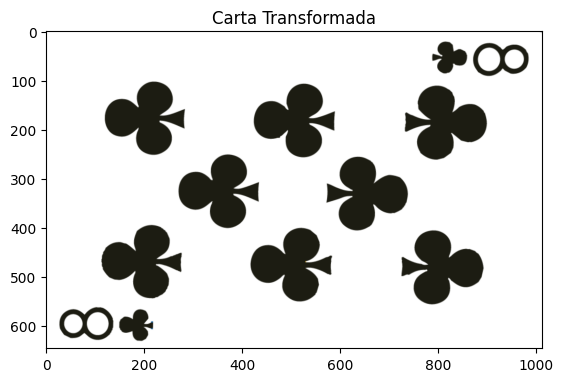

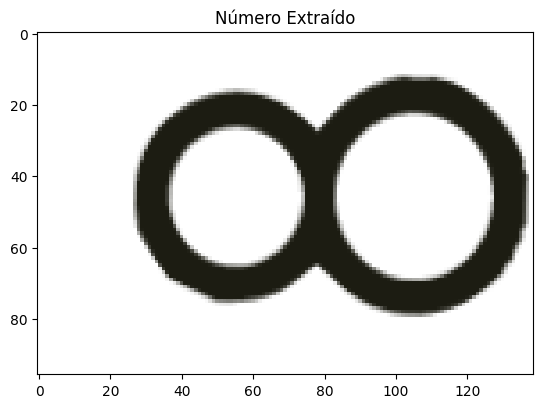

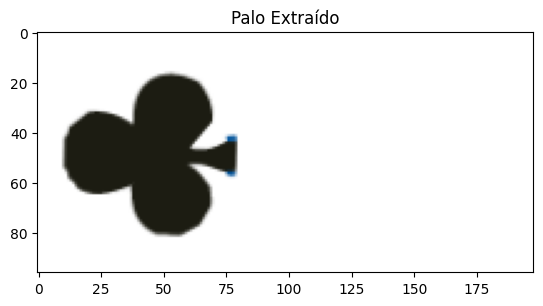

La carta detectada es: 2 de Hearts


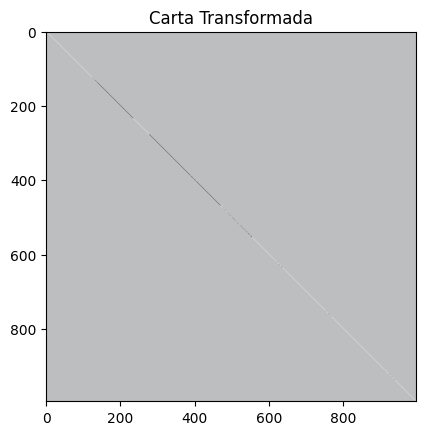

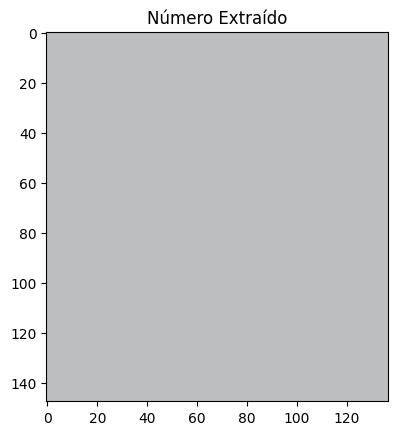

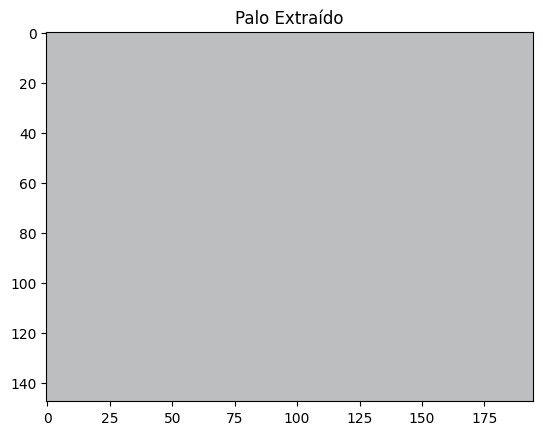

La carta detectada es: Ace de Clubs


In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para preprocesar la imagen: convertir a escala de grises, aplicar filtro gaussiano y mejorar el contraste.
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    enhanced = cv2.equalizeHist(blurred)  # Mejorar el contraste
    _, thresholded = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Binarizar
    return thresholded

# Función para detectar bordes utilizando el algoritmo de Canny
def detect_edges(image):
    edges = cv2.Canny(image, 100, 200)
    return edges

# Función para encontrar los contornos de las cartas en la imagen
def find_cards_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Función para filtrar contornos de la carta
def filter_card_contours(contours):
    card_contours = []
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            card_contours.append(approx)
    return card_contours

# Función para transformar la perspectiva de la carta a una vista frontal
def transform_perspective(image, contour):
    # Obtener el tamaño de la imagen
    image_width = image.shape[1]
    
    # Ajustar el orden de los puntos de contorno (para reflejar la imagen en espejo)
    pts1 = np.float32([contour[0][0], contour[1][0], contour[2][0], contour[3][0]])

    # Reflejar las coordenadas horizontales (invirtiendo el eje X)
    pts1_mirror = np.float32([[image_width - pt[0], pt[1]] for pt in pts1])
    
    # Calcular la anchura y la altura de la carta transformada
    width = max(np.linalg.norm(pts1_mirror[0] - pts1_mirror[1]), np.linalg.norm(pts1_mirror[2] - pts1_mirror[3]))
    height = max(np.linalg.norm(pts1_mirror[0] - pts1_mirror[3]), np.linalg.norm(pts1_mirror[1] - pts1_mirror[2]))
    
    # Definir los puntos de salida de la transformación de perspectiva
    pts2 = np.float32([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]])
    
    # Definir la matriz de transformación
    matrix = cv2.getPerspectiveTransform(pts1_mirror, pts2)
    
    # Realizar la transformación de perspectiva
    warped = cv2.warpPerspective(image, matrix, (int(width), int(height)))
    return warped

# Función para extraer las regiones del número y del palo de la carta
def extract_number_and_suit_regions(card_image):
    height, width = card_image.shape[:2]
    
    # Calcular el primer tercio de la anchura y el primer cuarto de la altura
    width_third = int(width / 3)  # Primer tercio de la anchura
    height_quarter = int(height / 6.7)  # Primer cuarto de la altura
    last_height_quarter = height-height_quarter
    
    width_2 = int(width_third/1.7) 
    
    # Ajustar las regiones de acuerdo con los nuevos cálculos
    number_region = card_image[last_height_quarter:height, int(width_third*0):(width_third-width_2)]  # Primer cuarto de altura y primer tercio de anchura
    suit_region = card_image[last_height_quarter:height, (width_third-width_2):int(width_third*1)]  # Resto de la carta (por ejemplo, el palo)

    return number_region, suit_region


# Función para extraer información de la carta (valor y palo) usando templates
def extract_card_info(number_image, suit_image, number_templates, suit_templates):
    # Preprocesar las regiones (número y palo)
    number_gray = cv2.cvtColor(number_image, cv2.COLOR_BGR2GRAY)
    _, number_thresholded = cv2.threshold(number_gray, 127, 255, cv2.THRESH_BINARY)
    
    suit_gray = cv2.cvtColor(suit_image, cv2.COLOR_BGR2GRAY)
    _, suit_thresholded = cv2.threshold(suit_gray, 127, 255, cv2.THRESH_BINARY)
    
    # Comparar con plantillas de números
    number_res = []
    for name, template in number_templates.items():
        # Rotar la plantilla 90 grados antihorario
        rotated_template = cv2.rotate(template, cv2.ROTATE_90_CLOCKWISE)
        
        # Realizar la comparación con la plantilla rotada
        result = cv2.matchTemplate(number_thresholded, rotated_template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        number_res.append((name, max_val))
    
    number_res.sort(key=lambda x: x[1], reverse=True)
    number = number_res[0][0]
    
    # Comparar con plantillas de palos
    suit_res = []
    for name, template in suit_templates.items():
        # Rotar la plantilla 90 grados antihorario
        rotated_template = cv2.rotate(template, cv2.ROTATE_90_CLOCKWISE)
        
        # Realizar la comparación con la plantilla rotada
        result = cv2.matchTemplate(suit_thresholded, rotated_template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(result)
        suit_res.append((name, max_val))
    
    suit_res.sort(key=lambda x: x[1], reverse=True)
    suit = suit_res[0][0]
    
    return number, suit


# Cargar las plantillas de los números y los palos
def load_templates():
    number_templates = {}
    suit_templates = {}
    
    # Plantillas de números
    number_templates['Ace'] = cv2.imread('Fotos/Plantillas/Ace.jpg', 0)
    number_templates['2'] = cv2.imread('Fotos/Plantillas/Two.jpg', 0)
    number_templates['3'] = cv2.imread('Fotos/Plantillas/Three.jpg', 0)
    number_templates['4'] = cv2.imread('Fotos/Plantillas/Four.jpg', 0)
    number_templates['5'] = cv2.imread('Fotos/Plantillas/Five.jpg', 0)
    number_templates['6'] = cv2.imread('Fotos/Plantillas/Six.jpg', 0)
    number_templates['7'] = cv2.imread('Fotos/Plantillas/Seven.jpg', 0)
    number_templates['8'] = cv2.imread('Fotos/Plantillas/Eight.jpg', 0)
    number_templates['9'] = cv2.imread('Fotos/Plantillas/Nine.jpg', 0)
    number_templates['10'] = cv2.imread('Fotos/Plantillas/Ten.jpg', 0)
    number_templates['Jack'] = cv2.imread('Fotos/Plantillas/Jack.jpg', 0)
    number_templates['Queen'] = cv2.imread('Fotos/Plantillas/Queen.jpg', 0)
    number_templates['King'] = cv2.imread('Fotos/Plantillas/King.jpg', 0)
    
    # Plantillas de palos
    suit_templates['Clubs'] = cv2.imread('Fotos/Plantillas/Clubs.jpg', 0)
    suit_templates['Diamonds'] = cv2.imread('Fotos/Plantillas/Diamonds.jpg', 0)
    suit_templates['Hearts'] = cv2.imread('Fotos/Plantillas/Hearts.jpg', 0)
    suit_templates['Spades'] = cv2.imread('Fotos/Plantillas/Spades.jpg', 0)
    
    return number_templates, suit_templates

# Cargar la imagen
image = cv2.imread('Fotos/fotos_sencillas/8C.png')

# Preprocesar la imagen
preprocessed_image = preprocess_image(image)

# Detectar bordes
edges = detect_edges(preprocessed_image)

# Encontrar los contornos en la imagen
contours = find_cards_contours(edges)

# Filtrar los contornos que corresponden a cartas
card_contours = filter_card_contours(contours)

# Dibujar los contornos de las cartas en la imagen original
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, card_contours, -1, (0, 255, 0), 2)

# Mostrar la imagen con los contornos detectados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Cartas Detectadas")
plt.show()

# Cargar las plantillas
number_templates, suit_templates = load_templates()

# Para cada carta detectada, obtener la subimagen transformada
for contour in card_contours:
    card_image = transform_perspective(image, contour)
    # Mostrar la carta transformada
    plt.imshow(cv2.cvtColor(card_image, cv2.COLOR_BGR2RGB))
    plt.title("Carta Transformada")
    plt.show()
    # Extraer las regiones del número y del palo
    number_region, suit_region = extract_number_and_suit_regions(card_image)
    
    # Mostrar las regiones extraídas
    plt.imshow(cv2.cvtColor(number_region, cv2.COLOR_BGR2RGB))
    plt.title("Número Extraído")
    plt.show()
    
    plt.imshow(cv2.cvtColor(suit_region, cv2.COLOR_BGR2RGB))
    plt.title("Palo Extraído")
    plt.show()
    
    # Extraer la información de la carta usando plantillas de números y palos
    number, suit = extract_card_info(number_region, suit_region, number_templates, suit_templates)
    
    # Mostrar la información extraída
    print(f'La carta detectada es: {number} de {suit}')
